### Importer les données

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")


# Charger les données client
df = pd.read_csv(
    r'C:\Users\gerard.kra\Documents\Doc_Stage\data_info_client_clean.csv',
    low_memory=False
)

In [3]:
# Taille de la donnée
print(df.shape)

(337524, 26)


In [2]:
# Vérification de valeurs manquantes dans vecteur produits
print(df['VECTEUR_PROD'].isnull())

0         False
1         False
2         False
3         False
4          True
          ...  
337519     True
337520    False
337521     True
337522     True
337523     True
Name: VECTEUR_PROD, Length: 337524, dtype: bool


In [3]:
# Visualisation des colonnes de notre jeu de données
df['VECTEUR_PROD'].unique()

array(['CCO PART. SEGMT. MASSE', 'COMPTES EPA AUT. PARTICULIER',
       'Visa CLASSIC Primo Non Package|CCO PART. SEGMT. INTERM. PLUS|COMPTES EPA AUT. PARTICULIER',
       ..., 'CCO PART. SEGMT. PRESTIGE|PLAN EPA AUTRE CREDIT',
       'PLANS EPARGNE LOGEMENT|CCO PART. SEGMT. PRESTIGE|COMPTES EPA AUT. PARTICULIER',
       'COMPTES EPA AUT. PARTICULIER|CCO PART. SEGMT. DISTINCTION'],
      dtype=object)

In [5]:
# Calcul de pourcentage des valeurs manquantes dans toutes les colonnes de notre données
pourcentage_nan = df.isna().mean() * 100
print(pourcentage_nan)

NUM                              1.628032
CLIENT                           0.000000
DATNAIS                          2.701141
DATE_EER                         0.000000
SEXE                             0.000000
TITUPRINC                        0.000000
IDP                              1.657660
SITUATIONMATRIMONAL              3.278582
CODE_SECTEUR_ACTIVITE            0.000000
SECTEUR_ACTIVITE_PAR_CODEAPE     1.488783
SEGMENT                          0.000000
PROFESSION                      33.932402
CODE_AGENT_ECO                   0.000000
LIBELLE_AGENT_ECO                0.000000
CIVILITE                         0.000000
AGE                              0.000000
ANCIENNETE_JOURS                 0.000000
CARTE                            0.000000
PRET                             0.000000
BNIONLINE                        0.000000
COMPTE                           0.000000
TYPE_CARTE                      57.645679
TYPE_PRET                       81.193337
TYPE_PROD_Bnionline             92

## Implémentation du modèle

- Cold‑start (sans produits) : on utilise kNN sur le profil → on calcule une proportion pondérée (fréquence chez les voisins pondérée par proximité), Puis :
  - Normalisation en [0,1] (score = somme des poids des voisins possédant le produit / somme totale des poids).
  - IDF : pénalise légèrement les produits trop dominants (ex. « compte épargne ») pour faire remonter des offres plus distinctives mais pertinentes.
  - MMR : diversifie le Top‑N en réduisant la redondance (similitudes de produits via embeddings).
- Clients avec produits : on garde la même logique mais on re‑note en [0,1] et on applique aussi MMR pour éviter 5 déclinaisons du même produit


##### Approche hybride utilisée
    - Cas 1 : Client avec produits → Recommandation produit → produit (content-based).
    - Cas 2 : Client sans produits → Recommandation profil → voisins (look‑alike).


In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout
from tensorflow.keras.models import Model
import time

df = df.copy()

# =============================
# 1. Nettoyage du texte client
# =============================
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))# Supprime la ponctuation
    text = re.sub(r'[^a-zA-Z0-9\\s]', '', text)  # Supprime caractères spéciaux et chiffres
    text = re.sub(r'\s+', ' ', text).strip()  # Supprime les espaces multiples
    return text

# =============================
# 2. Nettoyage des produits
# =============================
def clean_product_name(name):
    if pd.isnull(name):
        return ""
    name = str(name).lower()
    name = name.translate(str.maketrans('', '', string.punctuation)) # Supprime la ponctuation
    name = re.sub(r'\s+', ' ', name).strip() # Supprime les espaces multiples
    return name

# =============================
# 3. Construction du texte client + produits
# =============================
def build_client_profile(row):
    return f"{clean_text(row['SEXE'])} {clean_text(row['TITUPRINC'])} {clean_text(row['SITUATIONMATRIMONAL'])} " \
           f"{clean_text(row['SEGMENT'])} {clean_text(row['PROFESSION'])} {clean_text(row['CIVILITE'])} " \
           f"age_{row['AGE']} anciennete_{row['ANCIENNETE_JOURS']}"

df["client_profile"] = df.apply(build_client_profile, axis=1)

df["clean_products"] = df["VECTEUR_PROD"].fillna('').apply(
    lambda x: [clean_product_name(p) for p in x.split('|') if p]
)

df["product_text"] = df["clean_products"].apply(lambda x: ' | '.join(x))  # pour affichage
df["product_text_for_tokenizer"] = df["clean_products"].apply(lambda x: '|'.join(x))  # pour tokenisation
df["full_text"] = df["client_profile"] + ' ' + df["product_text"]

# =============================
# 4. Tokenisation (produits uniquement)
# =============================
tokenizer = Tokenizer(lower=False, split='|')  # chaque produit est un token
tokenizer.fit_on_texts(df["product_text_for_tokenizer"])
sequences = tokenizer.texts_to_sequences(df["product_text_for_tokenizer"])

word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id) + 1

# =============================
# 5. Skip-Gram
# =============================
pairs, labels = [], []
for seq in sequences:
    sg_pairs, sg_labels = skipgrams(seq, vocabulary_size=vocab_size, window_size=2, negative_samples=1)
    pairs.extend(sg_pairs)
    labels.extend(sg_labels)

pairs = np.array(pairs)
labels = np.array(labels)

# =============================
# 6. Modèle Skip-Gram
# =============================
embedding_size = 50
input_target = Input(shape=(1,))
input_context = Input(shape=(1,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=1, name="embedding")
target_vector = Dropout(0.2)(Flatten()(embedding(input_target)))
context_vector = Dropout(0.2)(Flatten()(embedding(input_context)))
dot_product = Dot(axes=1)([target_vector, context_vector])
output = Dense(1, activation="sigmoid")(dot_product)
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam")

# =============================
# 7. Entraînement
# =============================
start_time = time.perf_counter()
model.fit([pairs[:, 0], pairs[:, 1]], labels, epochs=50, batch_size=128, verbose=1)
end_time = time.perf_counter()
print(f"Temps d'entraînement du modèle Skip-Gram : {end_time - start_time:.2f} secondes")

# =============================
# 8. Embeddings
# =============================
embedding_matrix = model.get_layer("embedding").get_weights()[0]

# ============================================
# 9) Recommandation hybride optimisée
# ============================================
def recommend_products_hybride_optim(
    client_index, df, embeddings,
    top_n=5,
    min_similarity=0.10,
    use_mmr=True,
    lambda_mmr=0.7,
    idf_alpha=0.30,        # force anti-popularité (0 = off, 1 = fort)
    tau_neighbors=0.80,    # voisins effectifs couvrant 80% du poids
    score_mode="relative"  # "relative" (top=1.0) ou "proportion"
):
    owned = set(df.iloc[client_index]["tokens_known"])
    cvec = embeddings[client_index]

    # ===== A) Client AVEC produits -> voisinage PRODUIT + MMR =====
    if not is_zero_vector(cvec) and len(owned) > 0:
        sims = cosine_similarity(cvec.reshape(1, -1), embeddings).ravel()
        candidate_scores = {}
        for idx in np.argsort(sims)[::-1][1:]:
            if sims[idx] < min_similarity:
                break
            for t in [t for t in df.iloc[idx]["tokens_known"] if t not in owned]:
                # cumul léger de similarité (favorise des produits vus chez plusieurs voisins proches)
                candidate_scores[t] = candidate_scores.get(t, 0.0) + float(sims[idx]) * 0.5

        if not candidate_scores:
            return []

        # Normalisation relative [0,1]
        max_s = max(candidate_scores.values())
        rel_scores = {t: (s / (max_s + 1e-12)) for t, s in candidate_scores.items()}

        # MMR
        if use_mmr:
            mmr = mmr_rerank(rel_scores, top_n=top_n, lambda_mmr=lambda_mmr)
            return [("produit", t, s) for t, s in mmr]
        else:
            recs = sorted(rel_scores.items(), key=lambda x: -x[1])[:top_n]
            return [("produit", t, float(s)) for t, s in recs]

    # ===== B) Cold-start -> Look-alike PROFIL (normalisé + IDF + MMR) =====
    row = df.iloc[client_index].to_dict()
    X_row = encode_profile_row(row)
    dists, idxs = knn_profile.kneighbors(X_row, return_distance=True)
    dists, idxs = dists[0], idxs[0]

    weights = np.maximum(1.0 - dists, 0.0)
    # Limiter aux voisins effectifs (80%)
    w_eff, i_eff = effective_neighbors(weights, idxs, tau=tau_neighbors)
    total_w = float(w_eff.sum()) + 1e-9

    base_scores = defaultdict(float)  # proportion pondérée
    cover = defaultdict(int)

    for w, j in zip(w_eff, i_eff):
        if j == client_index:
            continue
        for t in df.iloc[j]["tokens_known"]:
            if t not in owned:
                base_scores[t] += float(w)
                cover[t]  += 1

    if not base_scores:
        return []

    # Proportion pondérée (0..1) sur voisins effectifs
    for t in list(base_scores.keys()):
        base_scores[t] = base_scores[t] / total_w

    # Anti-popularité douce
    if idf_alpha > 0:
        for t in list(base_scores.keys()):
            base_scores[t] *= (1.0 - idf_alpha) + idf_alpha * idf_norm.get(t, 0.0)

    # Final: soit garder la proportion, soit renormaliser "relative" (top=1)
    if score_mode == "relative":
        m = max(base_scores.values())
        final_scores = {t: base_scores[t] / (m + 1e-12) for t in base_scores}
    else:
        final_scores = base_scores  # proportions pondérées

    if use_mmr:
        mmr = mmr_rerank(final_scores, top_n=top_n, lambda_mmr=lambda_mmr)
        # Retourner aussi la couverture (nb voisins possédant)
        return [("lookalike", t, s, cover[t]) for t, s in mmr]
    else:
        recs = sorted(final_scores.items(), key=lambda x: -x[1])[:top_n]
        return [("lookalike", t, float(s), cover[t]) for t, s in recs]

# ============================================
# 10) Démo : 10 premiers clients
# ============================================
n_test = min(10, len(df))
for i in range(n_test):
    recs = recommend_products_hybride_optim(
        client_index=i,
        df=df,
        embeddings=embeddings,
        top_n=5,
        min_similarity=0.60,
        use_mmr=True,
        lambda_mmr=0.7,
        idf_alpha=0.20,       # plus doux que 0.5
        tau_neighbors=0.80,   # voisins effectifs (couvre 80% du poids)
        score_mode="relative" # affichage plus lisible (top=1.0)
    )
    owned = df.iloc[i]["tokens_known"]
    print(f"\nClient {i}")
    print(f"Possède déjà : {sorted(owned)}")
    print("Recommandations :")
    for r in recs:
        if r[0] == "produit":
            _, prod, score = r
            print(f"  - {prod}  (score: {score:.4f}, méthode: voisinage-produit + MMR)")
        else:
            _, prod, score, cov = r
            print(f"  - {prod}  (score: {score:.4f}, voisins+: {cov}, méthode: lookalike + IDF + MMR)")



C:\Users\gerard.kra\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.4099
Epoch 2/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 0.2835
Epoch 3/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 0.2800
Epoch 4/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 0.2771
Epoch 5/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 0.2762
Epoch 6/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - loss: 0.2757
Epoch 7/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 0.2748
Epoch 8/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 143s 5ms/step - loss: 0.2750
Epoch 9/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - loss: 0.2749
Epoch 10/10
22331/22331 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 0.2751
⏱️ Temps d'entraînement du modèle Skip-Gram : 1210.82 secondes
🧾 Produits déjà possédés par le client 0 : ['cco part segmt masse']
📌 Recommandations Keras Embedding pour le client 0 :
  - cco part segmt interm (score : 0.98276)
  - cco part segmt interm plus (score : 0

### Visualisation 2D des produits à l'aide de T-SNE

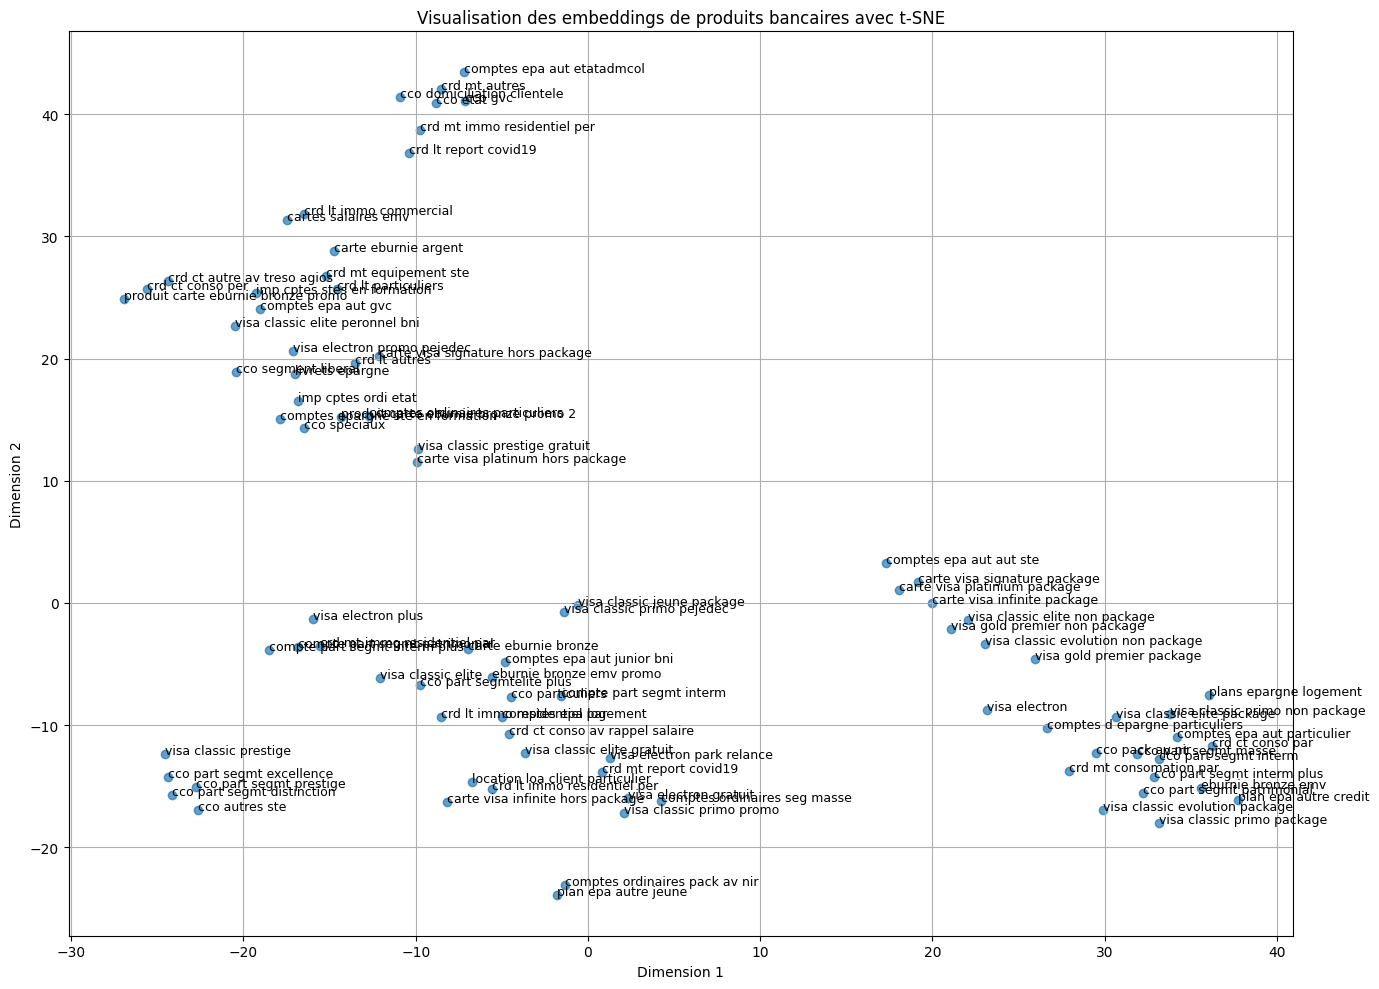

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# On extrait les vecteurs et les mots correspondants
words = list(word2id.keys())
vectors = np.array([embedding_matrix[word2id[word]] for word in words])

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced = tsne.fit_transform(vectors)

# Visualisation
plt.figure(figsize=(14, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)

# Affichage des noms de produits
for i, word in enumerate(words):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=9)

plt.title("Visualisation des embeddings de produits bancaires avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig("Visualisation-embedding.png")


## Sauvegarde du modèle

In [ ]:
import joblib
import numpy as np

# 1. Sauvegarder le modèle Keras complet
model.save("skipgram_model.keras")

# 2. Sauvegarder le tokenizer
joblib.dump(tokenizer, "tokenizer.joblib")

# 3. Sauvegarder word2id
joblib.dump(word2id, "word2id2.joblib")

# 4. Sauvegarder la matrice d'embedding
np.save("embedding_matrix.npy", embedding_matrix)


## Cas d'usage du modèle

In [ ]:
from tensorflow.keras.models import load_model

# 1. Charger le modèle
model = load_model("skipgram_model.keras")

# 2. Charger le tokenizer
tokenizer = joblib.load("tokenizer.joblib")

# 3. Charger word2id
word2id = joblib.load("word2id.joblib")

# 4. Charger la matrice d'embedding
embedding_matrix = np.load("embedding_matrix.npy")


## USAGE DU MODEL APRES SAUVEGARDE

In [3]:
# ============================================
# 0) Imports
# ============================================
import numpy as np
import pandas as pd
import re, string
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack, csr_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

# ============================================
# 1) Artefacts
# ============================================
word2id = joblib.load("word2id.joblib")
embedding_matrix = np.load("embedding_matrix.npy")
embedding_size = embedding_matrix.shape[1]
id2word = {v: k for k, v in word2id.items()}

# ============================================
# 2) Nettoyage / Tokenisation (identique au train)
# ============================================
def clean_product_name(name):
    if name is None:
        return ""
    name = str(name).lower()
    name = name.translate(str.maketrans('', '', string.punctuation))
    name = re.sub(r'\s+', ' ', name).strip()
    return name

def tokenize_vecteur_prod(vprod_str):
    if pd.isna(vprod_str):
        return []
    return [clean_product_name(p) for p in str(vprod_str).split('|') if p]

# ============================================
# 3) Vecteurs
# ============================================
def client_vector_from_tokens(tokens, embedding_matrix, word2id, embedding_size):
    idx = [word2id[t] for t in tokens if t in word2id]
    if not idx:
        return np.zeros(embedding_size, dtype='float32')
    return embedding_matrix[idx].mean(axis=0).astype('float32')

def is_zero_vector(v, tol=1e-8):
    v = np.asarray(v)
    return np.all(np.abs(v) < tol)

def product_vec(token):
    if token in word2id:
        return embedding_matrix[word2id[token]]
    return None

# ============================================
# 4) Préparer df
# ============================================
df = df.copy()
if "VECTEUR_PROD" not in df.columns:
    raise ValueError("La colonne 'VECTEUR_PROD' est introuvable dans df.")

df["tokens"] = df["VECTEUR_PROD"].fillna("").apply(tokenize_vecteur_prod)
df["tokens_known"] = df["tokens"].apply(lambda toks: [t for t in toks if t in word2id])
df["vecteur_client"] = df["tokens_known"].apply(
    lambda toks: client_vector_from_tokens(toks, embedding_matrix, word2id, embedding_size)
)
embeddings = np.vstack(df["vecteur_client"].to_numpy())

# ============================================
# 5) IDF anti-popularité (douce)
# ============================================
def build_idf(df, word2id):
    N = len(df)
    df_counts = Counter()
    for toks in df["tokens_known"]:
        df_counts.update(set(toks))  # présence binaire
    idf_raw = {t: np.log((N + 1) / (df_counts.get(t, 0) + 1)) + 1.0 for t in word2id.keys()}# formule idf evite la /0
    max_idf = max(idf_raw.values()) if idf_raw else 1.0
    idf_norm = {t: (v / max_idf) for t, v in idf_raw.items()}  # idf nomalisée par le max pour que idf soit dans [0,1] 
    return idf_norm, df_counts

idf_norm, df_counts = build_idf(df, word2id)

# ============================================
# 6) Encodage PROFIL + kNN
# ============================================
cat_cols = ["SEXE","TITUPRINC","SITUATIONMATRIMONAL","SEGMENT","PROFESSION","CIVILITE"]
num_cols = ["AGE","ANCIENNETE_JOURS"]

for c in cat_cols:
    if c not in df.columns:
        df[c] = "NA"
for c in num_cols:
    if c not in df.columns:
        df[c] = 0

df_cat = df[cat_cols].fillna("NA").astype(str)
df_num = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# OneHotEncoder (compat 1.4+ et ≤1.3)
try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=True)

X_cat = enc.fit_transform(df_cat)
scaler = StandardScaler()
X_num = scaler.fit_transform(df_num.values.astype(float))
X = hstack([X_cat, csr_matrix(X_num)]) # conversion des tableaux de façon horizontale

n_neighbors_profile = 100
knn_profile = NearestNeighbors(n_neighbors=n_neighbors_profile, metric="cosine")
knn_profile.fit(X)

def encode_profile_row(row_dict):
    row_cat = {c: str(row_dict.get(c, "NA")) if pd.notna(row_dict.get(c, None)) else "NA" for c in cat_cols}
    df_row_cat = pd.DataFrame([row_cat], columns=cat_cols)
    Xc = enc.transform(df_row_cat)

    row_num = {}
    for c in num_cols:
        v = row_dict.get(c, 0)
        try:
            v = float(v)
        except:
            v = 0.0
        row_num[c] = v
    df_row_num = pd.DataFrame([row_num], columns=num_cols)
    Xn = scaler.transform(df_row_num.values.astype(float))

    return hstack([Xc, csr_matrix(Xn)])

# ============================================
# 7) Diversification MMR (Maximal Marginal Relevance) pour éviter de recommander 5 variantes très similaires.
# ============================================
def mmr_rerank(candidates, top_n=5, lambda_mmr=0.7):
    """
    candidates: dict {token: relevance in [0,1]}
    Retourne: liste [(token, relevance_retained)]
    """
    if not candidates:
        return []
    selected, remaining = [], set(candidates.keys())
    vecs = {t: product_vec(t) for t in candidates.keys()}

    def sim_prod(a, b): # similarité cosinus: formule classique
        va, vb = vecs.get(a), vecs.get(b)
        if va is None or vb is None:
            return 0.0
        denom = (np.linalg.norm(va)+1e-9) * (np.linalg.norm(vb)+1e-9)
        return float(np.dot(va, vb) / denom)

    while remaining and len(selected) < top_n:
        best_t, best_score = None, -1e9
        for t in list(remaining):
            relevance = float(candidates[t])
            redundancy = max([sim_prod(t, s) for s in selected], default=0.0)
            mmr_score = lambda_mmr * relevance - (1 - lambda_mmr) * redundancy
            if mmr_score > best_score:
                best_score, best_t = mmr_score, t
        selected.append(best_t)
        remaining.remove(best_t)
    return [(t, float(candidates[t])) for t in selected]

# ============================================
# 8) Voisins effectifs (80% du poids cumulé)
# ============================================
def effective_neighbors(weights, idxs, tau=0.8):
    """Retourne (weights_eff, idxs_eff) limités au plus petit préfixe couvrant tau du poids total."""
    order = np.argsort(weights)[::-1] # tri indice décroissant; par defaut argsort(): tri croissant
    w_sorted = weights[order]
    i_sorted = idxs[order]
    total = w_sorted.sum() + 1e-9
    cumsum = np.cumsum(w_sorted) # somme cumulée 
    k_eff = int(np.searchsorted(cumsum, tau * total, side="left")) + 1
    return w_sorted[:k_eff], i_sorted[:k_eff]

# ============================================
# 9) Recommandation hybride optimisée
# ============================================
def recommend_products_hybride_optim(
    client_index, df, embeddings,
    top_n=5,
    min_similarity=0.10,
    use_mmr=True,
    lambda_mmr=0.7,
    idf_alpha=0.30,        # force anti-popularité (0 = off, 1 = fort)
    tau_neighbors=0.80,    # voisins effectifs couvrant 80% du poids
    score_mode="relative"  # "relative" (top=1.0) ou "proportion"
):
    owned = set(df.iloc[client_index]["tokens_known"])
    cvec = embeddings[client_index]

    # ===== A) Client AVEC produits -> voisinage PRODUIT + MMR =====
    if not is_zero_vector(cvec) and len(owned) > 0:
        sims = cosine_similarity(cvec.reshape(1, -1), embeddings).ravel()
        candidate_scores = {}
        for idx in np.argsort(sims)[::-1][1:]:
            if sims[idx] < min_similarity:
                break
            for t in [t for t in df.iloc[idx]["tokens_known"] if t not in owned]:
                # cumul léger de similarité (favorise des produits vus chez plusieurs voisins proches)
                candidate_scores[t] = candidate_scores.get(t, 0.0) + float(sims[idx]) * 0.5

        if not candidate_scores:
            return []

        # Normalisation relative [0,1]
        max_s = max(candidate_scores.values())
        rel_scores = {t: (s / (max_s + 1e-12)) for t, s in candidate_scores.items()}

        # MMR
        if use_mmr:
            mmr = mmr_rerank(rel_scores, top_n=top_n, lambda_mmr=lambda_mmr)
            return [("produit", t, s) for t, s in mmr]
        else:
            recs = sorted(rel_scores.items(), key=lambda x: -x[1])[:top_n]
            return [("produit", t, float(s)) for t, s in recs]

    # ===== B) Cold-start -> Look-alike PROFIL (normalisé + IDF + MMR) =====
    row = df.iloc[client_index].to_dict()
    X_row = encode_profile_row(row)
    dists, idxs = knn_profile.kneighbors(X_row, return_distance=True)
    dists, idxs = dists[0], idxs[0]

    weights = np.maximum(1.0 - dists, 0.0)
    # Limiter aux voisins effectifs (80%)
    w_eff, i_eff = effective_neighbors(weights, idxs, tau=tau_neighbors)
    total_w = float(w_eff.sum()) + 1e-9

    base_scores = defaultdict(float)  # proportion pondérée
    cover = defaultdict(int)

    for w, j in zip(w_eff, i_eff):
        if j == client_index:
            continue
        for t in df.iloc[j]["tokens_known"]:
            if t not in owned:
                base_scores[t] += float(w)
                cover[t]  += 1

    if not base_scores:
        return []

    # Proportion pondérée (0..1) sur voisins effectifs
    for t in list(base_scores.keys()):
        base_scores[t] = base_scores[t] / total_w

    # Anti-popularité douce
    if idf_alpha > 0:
        for t in list(base_scores.keys()):
            base_scores[t] *= (1.0 - idf_alpha) + idf_alpha * idf_norm.get(t, 0.0)

    # Final: soit garder la proportion, soit renormaliser "relative" (top=1)
    if score_mode == "relative":
        m = max(base_scores.values())
        final_scores = {t: base_scores[t] / (m + 1e-12) for t in base_scores}
    else:
        final_scores = base_scores  # proportions pondérées

    if use_mmr:
        mmr = mmr_rerank(final_scores, top_n=top_n, lambda_mmr=lambda_mmr)
        # Retourner aussi la couverture (nb voisins possédant)
        return [("lookalike", t, s, cover[t]) for t, s in mmr]
    else:
        recs = sorted(final_scores.items(), key=lambda x: -x[1])[:top_n]
        return [("lookalike", t, float(s), cover[t]) for t, s in recs]

# ============================================
# 10) Démo : 10 premiers clients
# ============================================
n_test = min(10, len(df))
for i in range(n_test):
    recs = recommend_products_hybride_optim(
        client_index=i,
        df=df,
        embeddings=embeddings,
        top_n=5,
        min_similarity=0.60,
        use_mmr=True,
        lambda_mmr=0.7,
        idf_alpha=0.20,       # plus doux que 0.5
        tau_neighbors=0.80,   # voisins effectifs (couvre 80% du poids)
        score_mode="relative" # affichage plus lisible (top=1.0)
    )
    owned = df.iloc[i]["tokens_known"]
    print(f"\nClient {i}")
    print(f"Possède déjà : {sorted(owned)}")
    print("Recommandations :")
    for r in recs:
        if r[0] == "produit":
            _, prod, score = r
            print(f"  - {prod}  (score: {score:.4f}, méthode: voisinage-produit + MMR)")
        else:
            _, prod, score, cov = r
            print(f"  - {prod}  (score: {score:.4f}, voisins+: {cov}, méthode: lookalike + IDF + MMR)")



Client 0
🧾 Possède déjà : ['cco part segmt masse']
📌 Recommandations :
  - comptes epa aut particulier  (score: 1.0000, méthode: voisinage-produit + MMR)
  - cco part segmt interm  (score: 0.5816, méthode: voisinage-produit + MMR)
  - crd mt consomation par  (score: 0.0525, méthode: voisinage-produit + MMR)
  - plans epargne logement  (score: 0.0993, méthode: voisinage-produit + MMR)
  - visa classic primo non package  (score: 0.2203, méthode: voisinage-produit + MMR)

Client 1
🧾 Possède déjà : ['comptes epa aut particulier']
📌 Recommandations :
  - cco part segmt masse  (score: 1.0000, méthode: voisinage-produit + MMR)
  - cco part segmt interm  (score: 0.8453, méthode: voisinage-produit + MMR)
  - visa classic primo non package  (score: 0.4503, méthode: voisinage-produit + MMR)
  - eburnie bronze emv  (score: 0.3715, méthode: voisinage-produit + MMR)
  - crd mt consomation par  (score: 0.0739, méthode: voisinage-produit + MMR)

Client 2
🧾 Possède déjà : ['cco part segmt interm plus'

## EVALUATION GLOBAL DU MODEL SUR TOUT LE JEU DE DONNEES

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# 1. Similarité moyenne entre produits recommandés et possédés
def average_similarity_to_owned(client_index, df, embedding_matrix, word2id, recommendations):
    owned_tokens = df.iloc[client_index]["tokens_known"]
    owned_vecs = [embedding_matrix[word2id[t]] for t in owned_tokens if t in word2id]
    if not owned_vecs:
        return None
    owned_matrix = np.vstack(owned_vecs)
    scores = []
    for rec in recommendations:
        token = rec[1]
        if token in word2id:
            rec_vec = embedding_matrix[word2id[token]].reshape(1, -1)
            sim = cosine_similarity(rec_vec, owned_matrix).mean()
            scores.append(sim)
    return np.mean(scores) if scores else None

# 2. Diversité intra-liste
def diversity_intralist(recommendations, embedding_matrix, word2id):
    rec_tokens = [r[1] for r in recommendations if r[0] in ["produit", "lookalike"]]
    rec_vecs = [embedding_matrix[word2id[t]] for t in rec_tokens if t in word2id]
    if len(rec_vecs) < 2:
        return None
    rec_matrix = np.vstack(rec_vecs)
    sim_matrix = cosine_similarity(rec_matrix)
    n = len(rec_vecs)
    sim_sum = np.sum(sim_matrix) - np.trace(sim_matrix)
    return sim_sum / (n * (n - 1))

# 3. Couverture globale
recommended_products = set()
similarities = []
diversities = []

n_test = min(len(df), len(df))
for i in range(n_test):
    recs = recommend_products_hybride_optim(
        client_index=i,
        df=df,
        embeddings=embeddings,
        top_n=5,
        min_similarity=0.10,
        use_mmr=True,
        lambda_mmr=0.7,
        idf_alpha=0.30,
        tau_neighbors=0.80,
        score_mode="exp"
    )
    recommended_products.update([r[1] for r in recs])
    sim = average_similarity_to_owned(i, df, embedding_matrix, word2id, recs)
    div = diversity_intralist(recs, embedding_matrix, word2id)
    if sim is not None:
        similarities.append(sim)
    if div is not None:
        diversities.append(div)

# Résultats
coverage = len(recommended_products)
avg_similarity = np.mean(similarities) if similarities else None
avg_diversity = np.mean(diversities) if diversities else None

print(f"Couverture globale : {coverage} produits recommandés uniques sur {n_test} clients.")
if avg_similarity is not None:
    print(f"Similarité moyenne aux produits possédés : {avg_similarity:.4f}")
else:
    print("Pas de similarité calculable.")
if avg_diversity is not None:
    print(f"Diversité intra-liste moyenne : {avg_diversity:.4f}")
else:
    print("Pas de diversité calculable.")


## Code Parallélisé pour accélérer l'évaluation globale

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import os

# ------------------------------
# 1) Fonctions pour l'évaluation
# ------------------------------

def average_similarity_to_owned(client_index, df, embedding_matrix, word2id, recommendations):
    owned_tokens = df.iloc[client_index]["tokens_known"]
    owned_vecs = [embedding_matrix[word2id[t]] for t in owned_tokens if t in word2id]
    if not owned_vecs:
        return None
    owned_matrix = np.vstack(owned_vecs)
    scores = []
    for rec in recommendations:
        token = rec[1]
        if token in word2id:
            rec_vec = embedding_matrix[word2id[token]].reshape(1, -1)
            sim = cosine_similarity(rec_vec, owned_matrix).mean()
            scores.append(sim)
    return np.mean(scores) if scores else None

def diversity_intralist(recommendations, embedding_matrix, word2id):
    rec_tokens = [r[1] for r in recommendations if r[0] in ["produit", "lookalike"]]
    rec_vecs = [embedding_matrix[word2id[t]] for t in rec_tokens if t in word2id]
    if len(rec_vecs) < 2:
        return None
    rec_matrix = np.vstack(rec_vecs)
    sim_matrix = cosine_similarity(rec_matrix)
    n = len(rec_vecs)
    sim_sum = np.sum(sim_matrix) - np.trace(sim_matrix)
    return sim_sum / (n * (n - 1))

# ------------------------------
# 2) Parallélisation en 12 blocs
# ------------------------------

# Globals worker-side (références des gros objets pour éviter de les repasser à chaque tâche)
_WORK_DF = None
_WORK_EMBEDDING_MATRIX = None
_WORK_WORD2ID = None
_WORK_EMBEDDINGS = None

def _init_worker(df, embedding_matrix, word2id, embeddings):
    """Initialise les variables globales dans chaque processus worker."""
    global _WORK_DF, _WORK_EMBEDDING_MATRIX, _WORK_WORD2ID, _WORK_EMBEDDINGS
    _WORK_DF = df
    _WORK_EMBEDDING_MATRIX = embedding_matrix
    _WORK_WORD2ID = word2id
    _WORK_EMBEDDINGS = embeddings

def _run_block(start_idx, stop_idx,
               top_n=5, min_similarity=0.10, use_mmr=True,
               lambda_mmr=0.7, idf_alpha=0.30, tau_neighbors=0.80, score_mode="exp"):
    """
    Traite les clients [start_idx, stop_idx) et retourne :
      - set des produits recommandés (couverture partielle)
      - somme des similarités + compte
      - somme des diversités + compte
    """
    rec_products = set()
    sim_sum = 0.0
    sim_cnt = 0
    div_sum = 0.0
    div_cnt = 0
    for i in range(start_idx, stop_idx):
        recs = recommend_products_hybride_optim(
            client_index=i,
            df=_WORK_DF,
            embeddings=_WORK_EMBEDDINGS,   
            top_n=top_n,
            min_similarity=min_similarity,
            use_mmr=use_mmr,
            lambda_mmr=lambda_mmr,
            idf_alpha=idf_alpha,
            tau_neighbors=tau_neighbors,
            score_mode=score_mode
        )
        rec_products.update([r[1] for r in recs])

        sim = average_similarity_to_owned(i, _WORK_DF, _WORK_EMBEDDING_MATRIX, _WORK_WORD2ID, recs)
        if sim is not None:
            sim_sum += float(sim)
            sim_cnt += 1

        div = diversity_intralist(recs, _WORK_EMBEDDING_MATRIX, _WORK_WORD2ID)
        if div is not None:
            div_sum += float(div)
            div_cnt += 1

    # Renvoyer uniquement des objets "simples" pour limiter le coût de transport
    return rec_products, sim_sum, sim_cnt, div_sum, div_cnt

def _make_blocks(n_total, n_blocks):
    """Découpe [0, n_total) en n_blocks tranches contiguës aussi équilibrées que possible."""
    indices = np.array_split(np.arange(n_total), n_blocks)
    blocks = []
    for idx in indices:
        if len(idx) == 0:
            continue
        blocks.append((int(idx[0]), int(idx[-1]) + 1))
    return blocks

if __name__ == "__main__":
    df = df.copy()

    # Nombre de cœurs dispo
    nombre_coeurs = multiprocessing.cpu_count()
    print(f" Nombre de cœurs disponibles : {nombre_coeurs}")

    # Paramètres globaux
    n_test = min(len(df), len(df))
    n_blocks = nombre_coeurs      #  1 bloc par cœur (12 dans ton cas)
    max_workers = nombre_coeurs   #  12 workers en parallèle

    blocks = _make_blocks(n_test, n_blocks)

    # Accumulateurs globaux
    recommended_products_global = set()
    sim_sum_total = 0.0
    sim_cnt_total = 0
    div_sum_total = 0.0
    div_cnt_total = 0

    # Lance les blocs en parallèle
    with ProcessPoolExecutor(
        max_workers=max_workers,
        initializer=_init_worker,
        initargs=(df, embedding_matrix, word2id, embeddings)
    ) as ex:
        futures = [
            ex.submit(
                _run_block,
                start, stop,
                5,       # top_n
                0.10,    # min_similarity
                True,    # use_mmr
                0.7,     # lambda_mmr
                0.30,    # idf_alpha
                0.80,    # tau_neighbors
                "exp"    # score_mode
            )
            for (start, stop) in blocks
        ]

        for fut in as_completed(futures):
            rec_set, ss, sc, ds, dc = fut.result()
            recommended_products_global |= rec_set
            sim_sum_total += ss
            sim_cnt_total += sc
            div_sum_total += ds
            div_cnt_total += dc

    # Agrégation finale
    coverage = len(recommended_products_global)
    avg_similarity = (sim_sum_total / sim_cnt_total) if sim_cnt_total else None
    avg_diversity = (div_sum_total / div_cnt_total) if div_cnt_total else None

    # Affichage
    print(f" Couverture globale : {coverage} produits recommandés uniques sur {n_test} clients.")
    if avg_similarity is not None:
        print(f" Similarité moyenne aux produits possédés : {avg_similarity:.4f}")
    else:
        print(" Pas de similarité calculable.")
    if avg_diversity is not None:
        print(f" Diversité intra-liste moyenne : {avg_diversity:.4f}")
    else:
        print(" Pas de diversité calculable.")


✅ Nombre de cœurs disponibles : 12
